# bias studies with full systematics

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [26]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize, basinhopping
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=4)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':20,
             'ytick.labelsize':20,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 44171,
  "iopub_port": 49993,
  "stdin_port": 60385,
  "control_port": 43473,
  "hb_port": 49077,
  "ip": "127.0.0.1",
  "key": "cb84fdf1-5ea62eb8fd5627cf7b5f31b6",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-950d4fc3-e874-4276-8ac7-78ee2e215cba.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [27]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/updated_e_sf/'
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee', 'mumu',  
              'emu', 
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
plot_labels = fh.fancy_labels

# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes, process_cut=0.1)
params = fit_data._parameters
params_pre = fit_data.get_params_init().values.copy()
sample = {cat:fit_data.mixture_model(params_pre, cat) for cat in fit_data._model_data.keys()}

In [11]:
# configure fit

# minimizer options
min_options = dict(#eps=1e-9, 
                   #xtol=1e-3, 
                   #ftol=1e-9, 
                   #stepmx=0.1, 
                   #maxCGit=50, 
                   #accuracy=1e-10,
                   disp=None
                  )

# configure the objective
mask = fit_data._pmask
mask[iparam] = False
fobj = partial(fit_data.objective,
               data = sample,
               do_bb_lite = True,
               lu_test = 2
              )

fobj_jac = partial(fit_data.objective_jacobian,
                   data = sample,
                   do_bb_lite = True,
                   lu_test = 2
                  )



In [12]:
# prepare scan data
pname = 'lumi'
iparam = list(params.index).index(pname)
if iparam <= 3:
    scan_vals = np.linspace(bounds[iparam][0], bounds[iparam][1], 11)
else:
    scan_vals = np.linspace(params_pre[iparam] - 2*params.err_init[iparam], params_pre[iparam] + 2*params.err_init[iparam], 11)
sample = {cat:fit_data.mixture_model(params_pre, cat) for cat in fit_data._model_data.keys()}

# carry out scan and save results
results = []
cost = []
sv_accept = []
cost_cache = []
for sv in tqdm_notebook(scan_vals):
    # randomize n.p.
    #fit_data._pval_init[4:] = params_pre[4:] + fit_data._perr_init[4:]*np.random.randn(params_pre[4:].size)
    
    # produce sample with statistical randomization
    #sample = {cat:fit_data.mixture_model(params_pre, cat, randomize=True) for cat in fit_data._model_data.keys()}
    
    # set scan value and carry out minimization
    fit_data._pval_fit[iparam] = sv
    pinit = fit_data._pval_init[mask]
    result = minimize(fobj, pinit,
                      jac = fobj_jac,
                      method = 'BFGS', 
                      options = min_options,
                     )
    
    sv_accept.append(sv)
    results.append(result.x)
    cost.append(result.fun)
    
    #print(fobj(pinit), result.fun, sv)
    #if result.success or result.status == 1:
    #    sv_accept.append(sv)
    #    results.append(result.x)
    #    cost.append(result.fun)
    #    
    #    # unpack cost cache
    #    #new_cache = []
    #    #for cat, cache in fit_data._cache.items():
    #    #    new_cache.extend(cache['cost'])
    #    #cost_cache.append(new_cache)
    #    
    #    #print(fit_data._cache['ee_cat_gt2_eq0']['cost'])
    #else:
    #    print(result)
    #    print(sv)
        

In [20]:
# fit scan data with a parabola and calculate curvature
results = np.array(results)
cost = np.array(cost)
sv_accept = np.array(sv_accept)
#cost_cache = np.array(cost_cache)

mask = cost >= 0 
nll_coeff = np.polyfit(sv_accept[mask], cost[mask], deg=2)#, w=np.exp(-0.5*(params_init[ix] - scan_points)**2/sigma_fisher**2))
nll_poly = np.poly1d(nll_coeff)
d_nll_poly = np.polyder(nll_poly, m=2)
sigma_post = 1/np.sqrt(d_nll_poly(0))

if params_pre[iparam] != 0:
    err = sigma_post*100/params_pre[iparam]
else:
    err = sigma_post*100
print(err)

1.993848824404391


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


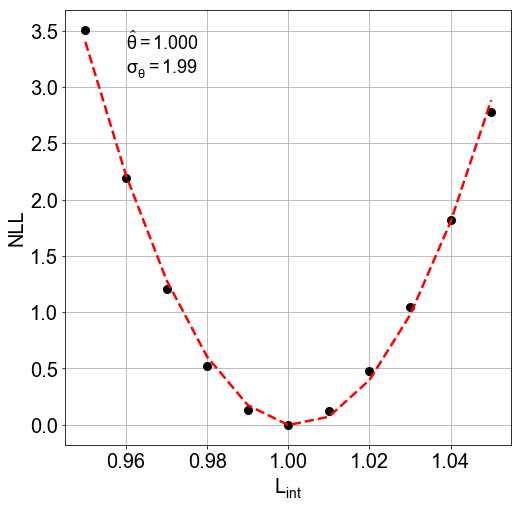

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8,8), facecolor='white')

ax.plot(sv_accept, cost, 'ko')
ax.plot(scan_vals, nll_poly(scan_vals), 'r--')
ax.grid()
ax.set_xlabel(params.loc[pname].label)
ax.set_ylabel('NLL')
ax.text(sv_accept[1], 0.95*np.max(cost), r'$\hat{\theta} = $' + f'{sv_accept[np.argmin(cost)]:.3f}')
ax.text(sv_accept[1], 0.89*np.max(cost), r'$\sigma_{\theta} = $' + f'{err:.2f}')

#ax.set_ylim(0, 10)

plt.savefig(f'plots/nll_scans/{pname}.png')
plt.show()

In [15]:
# unpack cached data

err = []
for i in range(cost_cache.shape[1]):
    #ax.plot(sv_accept, cost_cache[:,i], 'o')
    
    nll_coeff = np.polyfit(sv_accept, cost_cache[:,i], deg=2)#, w=np.exp(-0.5*(params_init[ix] - scan_points)**2/sigma_fisher**2))
    nll_poly = np.poly1d(nll_coeff)
    d_nll_poly = np.polyder(nll_poly, m=2)
    sigma = 1/np.sqrt(d_nll_poly(0))
    err.append((sigma**2)/(sigma_post**2))
    
err = np.array(err)
err[np.isnan(err)] = np.inf

fig, axes = plt.subplots(5, 1, facecolor='white', figsize=(20, 16))
selections = ['ll', 'emu', 'mutau', 'etau', 'lh']
for ix, selection in enumerate(selections):
    ax = axes[ix]
    if selection == 'll':
        ax.set_title(r'$ee/\mu\mu$', fontsize=16)
        imin, imax = 0, 90 # ee, mumu
    elif selection == 'emu':
        ax.set_title(r'$e\mu$', fontsize=16)
        imin, imax = 90, 178 # emu
    elif selection == 'mutau':
        ax.set_title(r'$\mu\tau$', fontsize=16)
        imin, imax = 178, 265 # mutau
    elif selection == 'etau':
        ax.set_title(r'$e\tau$', fontsize=16)
        imin, imax = 265, 345 # etau
    elif selection == 'lh':
        ax.set_title(r'$e/\mu+h$', fontsize=16)
        imin, imax = 345, 401 # e4j, mu4j

    # get bins per category
    ibin = 0
    err_max = np.max(1/err[imin:imax])
    for cat, data in fit_data._model_data.items():

        nbins = data['data'][0].size
        ibin += nbins
        if ibin <= imin or ibin > imax: 
            continue

        jet_cat = '_'.join(cat.split('_')[1:])
        jet_cat = pt.categories[jet_cat].label 
        ax.text(ibin-nbins+1, 1.05*err_max, jet_cat, rotation=0, fontsize=14)
        ax.plot([ibin, ibin], [0, 1.5*err_max], 'r:')

    #ax.bar(np.arange(cost_cache.shape[1]), 1/err)
    ax.bar(np.arange(imin, imax), 1/err[imin:imax], align='edge')

    ax.grid(axis='Y')
    ax.set_xlim(imin, imax)
    ax.set_ylim(0, 1.2*err_max)
    ax.set_xlabel('bin')
    if ix == 2:
        ax.set_ylabel(r'$\partial^{2}NLL_{bin}/\partial^{2}NLL_{total}$')

plt.tight_layout()
plt.savefig(f'plots/nll_scans/{pname}_scan_bins_{selection}.png')
plt.show()

AttributeError: 'list' object has no attribute 'shape'